In [1]:
from scipy.spatial import Delaunay
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(0)
points = np.random.rand(100, 2)

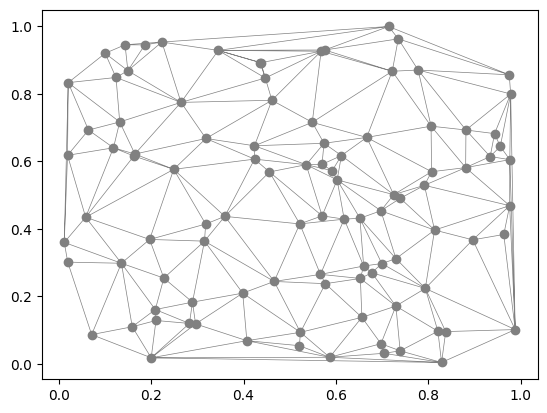

In [3]:
plt.scatter(points[:, 0], points[:, 1], color="gray")
plt.triplot(points[:, 0], points[:, 1], color="gray", lw=0.5)

Use Delaunay Triangulation to find neighbors with [vertex_neighbor_vertices](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Delaunay.vertex_neighbor_vertices.html#scipy.spatial.Delaunay.vertex_neighbor_vertices)

In [4]:
dt = Delaunay(points)
indptr, indices = dt.vertex_neighbor_vertices

In [5]:
len(indptr), len(indices)

(101, 568)

In [6]:
indptr

array([  0,   6,  14,  20,  24,  27,  33,  40,  44,  50,  56,  63,  69,
        75,  79,  85,  94,  99, 104, 110, 114, 121, 126, 133, 137, 144,
       149, 157, 163, 169, 176, 181, 187, 193, 198, 202, 209, 215, 220,
       225, 230, 234, 238, 244, 251, 256, 262, 268, 274, 282, 289, 294,
       299, 307, 311, 317, 323, 328, 335, 342, 348, 355, 359, 365, 368,
       374, 380, 388, 392, 398, 404, 409, 412, 418, 422, 427, 433, 437,
       442, 447, 453, 459, 466, 470, 475, 482, 485, 493, 502, 510, 514,
       520, 525, 530, 538, 543, 549, 552, 556, 561, 568], dtype=int32)

In [7]:
indices[0:6]

array([81, 22,  6, 68,  2, 11], dtype=int32)

See the particle of interest and neighbors.

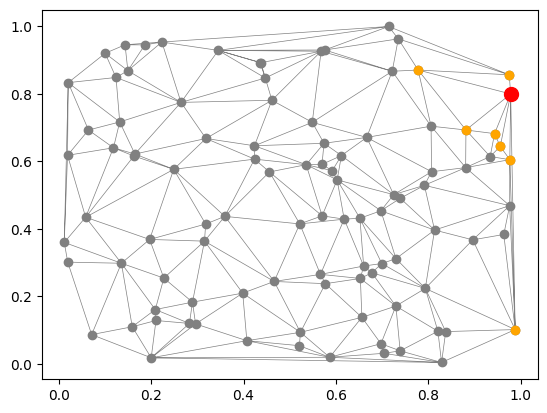

In [11]:
i = 10
neighbor_indices = indices[indptr[i]: indptr[i+1]]
plt.scatter(points[:, 0], points[:, 1], color="gray")
plt.triplot(points[:, 0], points[:, 1], color="gray", lw=0.5)
plt.scatter(points[i, 0], points[i, 1], color="red", s=100)
plt.scatter(points[neighbor_indices, 0], points[neighbor_indices, 1], color="orange")

Construct neighborlist as in Nathan's code: array of particle number list.

In [12]:
indptr

array([  0,   6,  14,  20,  24,  27,  33,  40,  44,  50,  56,  63,  69,
        75,  79,  85,  94,  99, 104, 110, 114, 121, 126, 133, 137, 144,
       149, 157, 163, 169, 176, 181, 187, 193, 198, 202, 209, 215, 220,
       225, 230, 234, 238, 244, 251, 256, 262, 268, 274, 282, 289, 294,
       299, 307, 311, 317, 323, 328, 335, 342, 348, 355, 359, 365, 368,
       374, 380, 388, 392, 398, 404, 409, 412, 418, 422, 427, 433, 437,
       442, 447, 453, 459, 466, 470, 475, 482, 485, 493, 502, 510, 514,
       520, 525, 530, 538, 543, 549, 552, 556, 561, 568], dtype=int32)

In [13]:
neighborlist = [indices[indptr[i]: indptr[i+1]] for i in range(len(indptr)-1)]


In [14]:
neighborlist

[array([81, 22,  6, 68,  2, 11], dtype=int32),
 array([18, 53, 60, 93, 25, 80, 69, 65], dtype=int32),
 array([62, 93, 45, 68,  0, 11], dtype=int32),
 array([88, 71,  6, 55], dtype=int32),
 array([35, 26, 70], dtype=int32),
 array([60, 97, 78, 58, 35, 57], dtype=int32),
 array([88,  3, 44,  0, 81, 11, 55], dtype=int32),
 array([30, 86, 66, 63], dtype=int32),
 array([17, 83, 41, 46, 77, 73], dtype=int32),
 array([51, 82, 81, 72, 10, 59], dtype=int32),
 array([36, 26,  9, 82, 61, 19, 59], dtype=int32),
 array([ 6,  0,  2, 45, 15, 55], dtype=int32),
 array([17, 41, 46, 90, 99, 76], dtype=int32),
 array([75, 73, 96, 54], dtype=int32),
 array([42, 29, 16, 25, 20, 65], dtype=int32),
 array([46, 90, 75, 54, 88, 77, 45, 11, 55], dtype=int32),
 array([14, 25, 93, 20, 62], dtype=int32),
 array([99, 83,  8, 41, 12], dtype=int32),
 array([ 1, 53, 60, 22, 68, 67], dtype=int32),
 array([61, 10, 59, 92], dtype=int32),
 array([16, 14, 40, 24, 52, 29, 62], dtype=int32),
 array([89, 48, 31, 84, 37], dtyp

Does it take too long for larger point sets?

In [45]:
points = np.random.rand(100000, 2)
dt = Delaunay(points)
indptr, indices = dt.vertex_neighbor_vertices
neighborlist = [indices[indptr[i]: indptr[i+1]] for i in range(len(indptr)-1)]

For a 100,000-point set, it takes 0.6 s to construct the neighborlist. In the current application, typical number of particle is < 10,000 each frame, so the performance is not an issue.

## Affine field

We first use Nathan's code. Since the k-d tree method is integrated in the `packing._affine_field` method, we need to rewrite the method.

In [137]:
import philatracks
import scipy

In [154]:
class dt_NNEngine(philatracks.packing.NNEngine):
    def _affine_field(self, d2min_scale=1.0, dview=None, neighbor_method="kdtree"):
        # Highly-optimized affine field computation, using a direct line to FORTRAN (LAPACK).
        # The prototype for this design is the map() method.
        def worker(data, loopindices, coords, nncutoff):
            # This runs only once on each engine so it's ok to have all this setup code
            tree = scipy.spatial.cKDTree(coords, 5) # 5 levels in the tree. YMMV.
            # Laughing in the face of danger, we use the Fortran linear system solver directly.
            solver, = scipy.linalg.lapack.get_lapack_funcs(('gelss',), (data, data))
            results = np.ones((len(loopindices), 5)) * np.nan # 5 output columns
            if neighbor_method == "kdtree":
                neighborlist = tree.query_ball_point(coords[loopindices], nncutoff)
            elif neighbor_method == "delaunay":
                dt = Delaunay(coords[loopindices])
                indptr, indices = dt.vertex_neighbor_vertices
                neighborlist = [indices[indptr[i]: indptr[i+1]] for i in range(len(indptr)-1)]
            for i, (pindex, neighbors) in enumerate(zip(loopindices, neighborlist)):
                if neighbor_indices == "kdtree":
                    neighbors.remove(pindex)
                if len(neighbors) < 2: continue  # Minimum to satisfy DOF
                r = data[neighbors] - np.tile(data[pindex], (len(neighbors), 1))
                # The rest of the loop body is computation-specific.
                try:
                    solvret = solver(r[:,0:2], r[:,2:4]) # v, x, s, rank, work, info
                    assert solvret[5] == 0 # "info"
                except:
                    continue # Did not converge or not enough data; results will be NaN
                results[i,:4] = solvret[1][:2].flat
                # NORMALIZE by number of particles
                results[i,4] = (solvret[1][2:]**2).sum() / len(neighbors) 
                # Uncommenting the assert below checks that D2min is equal to the residual.
                #assert np.allclose(results[i,4], np.sum((r[:,0:2].dot(gelret[1][:2]) \
                        #- r[:,2:4])**2) / len(neighbors)) 
            return results
        alldata = self.frametracks[['x', 'y', 'x0', 'y0']].values
        allresults = np.ones((alldata.shape[0], 5)) * np.nan
        if dview is None:
            # Single-threaded
            allresults[self.loopindices] = worker(alldata, self.loopindices, self.coords, self.nncutoff)
        else: # IPython parallel computing
            from IPython.parallel.util import interactive
            dview.execute('''import scipy.linalg.lapack, scipy.spatial''')
            dview.execute('''import numpy as np''')
            # To send function to engines, its parent namespace must be the global namespace. 
            dview['worker'] = interactive(worker)
            dview['data'] = alldata
            # Each engine considers a different set of particles
            dview.scatter('loopindices', self.loopindices) 
            dview['coords'] = self.coords
            dview['nncutoff'] = self.nncutoff
            dview.execute('''results = worker(data, loopindices, coords, nncutoff)''')
            allresults[self.loopindices] = dview.gather('results', block=True)
        rtr = self.frametracks.copy()
        for i, name in enumerate(['xdil', 'vstrain', 'hstrain', 'ydil', 'd2min']):
            rtr[name] = allresults[:,i]
        # FURTHER NORMALIZE by interparticle distance, if provided.
        rtr['d2min'] = rtr.d2min / d2min_scale**2
        return rtr

#### Test `philatracks` with synthetic data

- part of the particles translate and rotate for a small angle
- all particles are subject to some noise

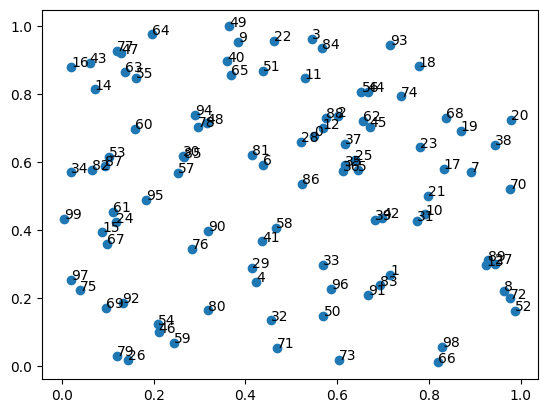

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
ftr0 = pd.DataFrame({"x": np.random.rand(100), "y": np.random.rand(100), 
                        "particle": np.arange(100), "frame": 0})
plt.scatter(ftr0.x, ftr0.y)
for num, i in ftr0.iterrows():
    plt.annotate(i.particle.astype("int"), (i.x, i.y), xycoords="data")

Select points (76, 90, 4, 29, 41, 58, 33) as the translation and rotation points.

In [2]:
poi = [76, 90, 4, 29, 41, 58, 33]
ftr1 = ftr0.copy()
# translate by 0.05
ftr1.loc[poi, "x"] += 0.02
# rotate about it's center of mass by 5 degrees
theta = np.radians(-15)
c, s = np.cos(theta), np.sin(theta)
rotation_matrix = np.array(((c, -s), (s, c)))
coords = ftr1.loc[poi, ["x", "y"]].values # N x 2
center_of_mass = coords.mean(axis=0)
coords_relative = coords - center_of_mass
coords_relative_rotated = np.matmul(rotation_matrix, coords_relative.T).T
coords_rotated = coords_relative_rotated + center_of_mass
ftr1.loc[poi, ["x", "y"]] = coords_rotated
# add a little bit noise to all points
ftr1["x"] += (np.random.rand(100) - 0.5) * 0.01
ftr1["y"] += (np.random.rand(100) - 0.5) * 0.01

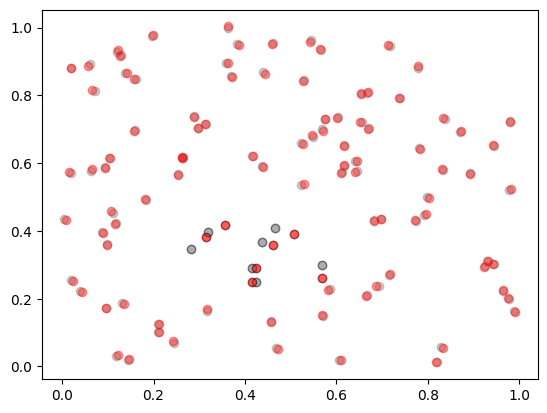

In [3]:
plt.scatter(ftr0.x, ftr0.y, color="gray", alpha=0.4)
plt.scatter(ftr1.x, ftr1.y, color="red", alpha=0.4)
plt.scatter(ftr0.loc[poi, "x"], ftr0.loc[poi, "y"], color="gray", alpha=0.4, ec="black")
plt.scatter(ftr1.loc[poi, "x"], ftr1.loc[poi, "y"], color="red", alpha=0.4, ec="black")

In [4]:
import philatracks

cutoff = 0.2
fast = False
subset = None
d2min_scale = 1.0
dview = None

ftrcomp = ftr1[['particle', 'x', 'y']].join(ftr0.set_index('particle')[['x', 'y']], 
                        on='particle', rsuffix='0').dropna()
NNE = philatracks.packing.NNEngine(ftrcomp, cutoff, fast=fast, subset=subset)
results = NNE._affine_field(d2min_scale=d2min_scale, dview=dview, neighbor_method="delaunay")

In [8]:
NNE._neighbor_list("kdtree")

NameError: name 'tree' is not defined

In [9]:
NNE.frametracks.reset_index(drop=True)

,particle,x,y,x0,y0
0,0,0.546931,0.681882,0.548814,0.677817
1,1,0.717153,0.272748,0.715189,0.270008
2,2,0.601541,0.733525,0.602763,0.735194
3,3,0.541679,0.958000,0.544883,0.962189
4,4,0.415930,0.248814,0.423655,0.248753
...,...,...,...,...,...
95,95,0.180435,0.495049,0.183191,0.490459
96,96,0.582491,0.225968,0.586513,0.227415
97,97,0.023729,0.252924,0.020108,0.254356
98,98,0.833669,0.053192,0.828940,0.058029


In [5]:
NNE.index_map

0      0
1      1
2      2
4      4
5      5
6      6
12    12
23    23
25    25
28    28
29    29
30    30
31    31
33    33
35    35
36    36
37    37
39    39
41    41
42    42
45    45
48    48
57    57
58    58
62    62
74    74
76    76
78    78
81    81
83    83
85    85
86    86
88    88
90    90
94    94
96    96
Name: particle, dtype: int32

`_affine_field` runs with `neighbor_method="delaunay"`, so the code is constructed in the right way. Whether the resulting data make sense is beyond my capability.

#### Can we return the neighborlist for manual check?

Yes

#### k-d tree and delaunay, which is faster?

In [158]:
points = np.random.rand(100000, 2)

In [166]:
# k-d tree
tree = scipy.spatial.cKDTree(points, 5)
neighborlist = tree.query_ball_point(points, 0.01)

The efficiency of k-d tree depends a lot on the cutoff distance. When distance is too large, so that the number of neighbors is large, the efficiency gets low. For a reasonable cutoff, where each node has a few neighbors, it is not slow. 0.01 is one of such reasonable cutoffs, and it takes 3 seconds to construct a neighborlist for a point set of 100,000.

In [168]:
# delaunay
dt = Delaunay(points)
indptr, indices = dt.vertex_neighbor_vertices
neighborlist = [indices[indptr[i]: indptr[i+1]] for i in range(len(indptr)-1)]

For delaunay method, no cutoff is needed since the algorithm always only finds the nearest "enclosing" neighbors. Therefore, direct comparison is not possible. However, delaunay algorithm is comparable to k-d tree algorithm at the small cutoff limit.

#### Can we also apply a cutoff distance to delaunay neighbors?

When I demonstrate the neighbor finding, I realize that the DT method can mistakenly take a very faraway point as a neighbor. This is likely when the POI is on the edge. Therefore, it is desired to have an additional criterion for neighbors: a cutoff distance.

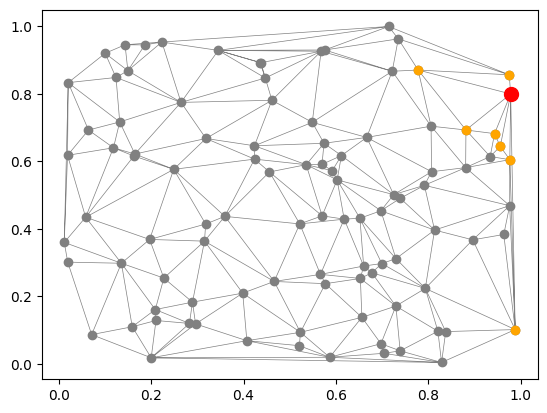

In [26]:
np.random.seed(0)
points = np.random.rand(100, 2)
dt = Delaunay(points)
indptr, indices = dt.vertex_neighbor_vertices

i = 10
neighbor_indices = indices[indptr[i]: indptr[i+1]]
plt.scatter(points[:, 0], points[:, 1], color="gray")
plt.triplot(points[:, 0], points[:, 1], color="gray", lw=0.5)
plt.scatter(points[i, 0], points[i, 1], color="red", s=100)
plt.scatter(points[neighbor_indices, 0], points[neighbor_indices, 1], color="orange")

In [27]:
neighborlist = [indices[indptr[i]: indptr[i+1]] for i in range(len(indptr)-1)]

In [28]:
cutoff = 0.2
for num, neighbor in enumerate(neighborlist):
    r = (points[neighbor, 0] - points[num, 0]) ** 2 + (points[neighbor, 1] - points[num, 1]) ** 2 
    neighborlist[num] = neighborlist[num][r<=cutoff**2]

Now the mistake of very faraway neighbor should be corrected.

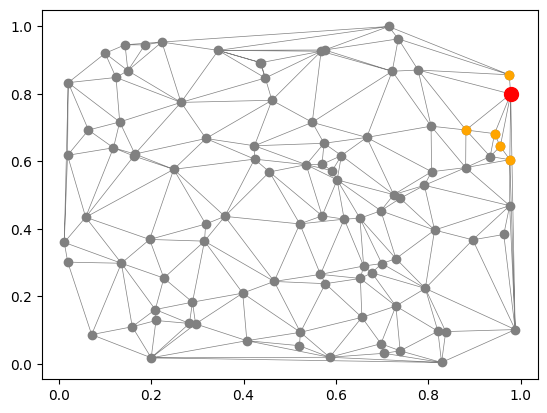

In [29]:
i = 10
neighbor_indices = neighborlist[i]
plt.scatter(points[:, 0], points[:, 1], color="gray")
plt.triplot(points[:, 0], points[:, 1], color="gray", lw=0.5)
plt.scatter(points[i, 0], points[i, 1], color="red", s=100)
plt.scatter(points[neighbor_indices, 0], points[neighbor_indices, 1], color="orange")

The filtering code involves a loop over all particles. Is speed a problem?

In [30]:
points = np.random.rand(100000, 2)
dt = Delaunay(points)
indptr, indices = dt.vertex_neighbor_vertices
neighborlist = [indices[indptr[i]: indptr[i+1]] for i in range(len(indptr)-1)]

cutoff = 0.1
for num, neighbor in enumerate(neighborlist):
    r = (points[neighbor, 0] - points[num, 0]) ** 2 + (points[neighbor, 1] - points[num, 1]) ** 2 
    neighborlist[num] = neighborlist[num][r<=cutoff**2]

For 100,000 points, it takes 1.4 seconds on my laptop. I consider this acceptable.

In [60]:
"""Characterize and compare particle packings.

Conventions:

``ftr`` or ``frametracks``
    a :py:class:`pandas.DataFrame` with columns "x", "y", "frame", "particle", arbitrarily indexed.
"""

import logging
import numpy as np
import scipy
import scipy.linalg.lapack, scipy.spatial

selfdistance = 1e-5 # Minimum separation for particles to be distinct


class NNEngine(object):
    """Tool for fast neighbor-based computations.

    Because it uses a KDTree algorithm to find nearest neighbors, expect a loop
    considering the neighbors of each particle to perform better than O(N log N).

    Creating an instance sets up which particles will be considered; the various methods are
    used to actually define and perform the computation.
    
    :param frametracks: DataFrame representing particles in 1 frame, that must have 
        "x" and "y" columns. A "particle" column is needed for the ``subset`` option.
    :param nncutoff: sets the maximum distance away to search for neighbors.
    :param nnmaxcount: is the maximum expected number of neighbors. This is irrelevant for
        the map() method.
    :param fast: if True, at most 10% of the particles are looped over (but all their neighbors 
        are still found). They are chosen randomly.
    :param autoclip: if True, particles within 'nncutoff' of the system edges are not 
        considered (assumes rectangular system).
    :param subset: is an array of particle IDs to loop over. 
        If ``autoclip`` is true, particles in ``subset`` but near the system edge are ignored.

    You can use any instance as an iterator; it returns (PID, neighbors) tuples,
    where 'neighbors' is a subset of the 'frametracks' DataFrame. Expect it to be slow
    because of all the pandas calls. The iter_raw() and map() methods are fast and
    useful.
    """
    def __init__(self, frametracks, nncutoff=9, nnmaxcount=100,
            fast=False, autoclip=True, subset=None):
        # Initialization of particle positions
        self.frametracks = frametracks
        self.coords = self.frametracks[['x', 'y']].values
        # Initialization of loop parameters
        self.nncutoff = nncutoff
        self.nnmaxcount = nnmaxcount
        self.autoclip = autoclip
        self.fast = fast
        self.loopindices = self._selected_indices(subset)
        self.nntree = None # Make later
    def makeTree(self):
        """cKDTree instance"""
        if self.nntree is None:
            self.nntree = scipy.spatial.ckdtree.cKDTree(self.coords, 5)
    def neighbors(self, pid):
        """Returns a DataFrame of particles around 'pid'"""
        x, y = self.frametracks[self.frametracks.particle == pid][['x', 'y']].values[0]
        return self.queryPoint(x, y)
    def queryPoint(self, x, y):
        """Returns DataFrame of particles near x, y. Checks that n < nnmaxcount."""
        self.makeTree()
        dists, inds = self.nntree.query((x, y), self.nnmaxcount,
                distance_upper_bound=self.nncutoff)
        r = self.frametracks.ix[self.frametracks.index.values.take(inds.compress((dists > selfdistance) & ~np.isinf(dists)))]
        if len(r) == self.nnmaxcount:
            logging.warning('Too many neighbors around (%f, %f); incrase nnmaxcount' \
                    % (x, y))
        return r
    def loopcount(self):
        """Number of particles that will be iterated over"""
        return len(self.loopindices)
    def __iter__(self):
        """Slow but friendly loop over all neighbors, using parameters passed
        to __init__(). See class docstring for a description."""
        for i in self.loopindices:
            pid = self.frametracks.particle.values[i]
            yield pid, self.neighbors(pid)
    def iter_raw(self, ftcols=['x', 'y']):
        """Maximally flexible fast loop based on a 'data' array constructed from the
        column names in 'ftcols'.
        
        Yields data[i], data[nn_i] tuples, where data[nn_i] is a 2D array.
        """
        self.makeTree()
        data = self.frametracks[ftcols].values
        coords = self.coords
        sd = selfdistance
        for i in self.loopindices:
            dists, inds = self.nntree.query(coords[i], self.nnmaxcount,
                    distance_upper_bound=self.nncutoff)
            yield data[i], data[inds.compress((dists > sd) & ~np.isinf(dists))]
    def iter_dist(self):
        """Loop returning only the distances of neighbors.
        
        Returns (x, y), distances tuples."""
        self.makeTree()
        coords = self.coords
        sd = selfdistance
        for i in self.loopindices:
            dists, inds = self.nntree.query(coords[i], self.nnmaxcount,
                    distance_upper_bound=self.nncutoff)
            yield coords[i], dists.compress((dists > sd) & ~np.isinf(dists))

    def _selected_indices(self, subset):
        """Indices of particles within 'nncutoff' of system edges.

        No cropping is performed if instance was initialized with 'autoclip=False'

        Length of returned array is limited if the 'fast' parameter was used.

        'subset' is a sequence of particle IDs
        """
        # We want the DataFrame to be indexed the same way its values array is
        ftr = self.frametracks.reset_index(drop=True)
        if subset is not None:
            ftr['tmpindex'] = ftr.index.values
            ftr = ftr.set_index('particle').reindex(subset).set_index('tmpindex')
        if self.autoclip:
            # Boundaries are computed for the whole system
            xmin = self.frametracks.x.min() + self.nncutoff
            xmax = self.frametracks.x.max() - self.nncutoff
            ymin = self.frametracks.y.min() + self.nncutoff
            ymax = self.frametracks.y.max() - self.nncutoff
            ftr = ftr.loc[ (ftr.x > xmin) & (ftr.x < xmax) & \
                    (ftr.y > ymin) & (ftr.y < ymax) ]
        self.index_map = ftr["particle"]
        r = ftr.index.values.astype(int)
        if self.fast:
            return np.random.permutation(r)[:int(len(r) / 10)]
        else:
            return r
    def map(self, fcn, incols, outcols, dview=None):
        """Evaluates a function for each particle, based on that particle and its
        neighbors.

        :param fcn: function to be called with ``data[i]``, ``data[nn_i]`` as arguments, 
            where ``data[nn_i]`` is a 2D array
        :param incols: list of column names in the original DataFrame, corresponding
            to the columns passed to ``fcn``.
        :param outcols: list of new column names, in which the value(s) returned by ``fcn``
            will be inserted.
        :param dview: optional IPython parallel direct view.
        
        Returns a copy of the original tracks DataFrame, with new columns from ``outcols``.
        """
        # Design notes:
        # - Things go the fastest and work the best when we send numpy arrays to the engines.
        #   In other words, avoid pickling at all costs.
        # - Pandas objects are slow. The algorithm should work with plain numpy arrays;
        #   we convert back to DataFrames at the end.
        alldata = self.frametracks[incols].values
        allresults = np.ones((alldata.shape[0], len(outcols))) * np.nan
        def worker(fcn, data, loopindices, coords, nncutoff, n_output_cols):
            # This runs only once on each engine so it's ok to have all this setup code
            import numpy as np
            import scipy.spatial.ckdtree
            tree = scipy.spatial.ckdtree.cKDTree(coords, 5)
            results = np.ones((len(loopindices), n_output_cols)) * np.nan
            neighborlist = tree.query_ball_point(coords[loopindices], nncutoff)
            for i, (pindex, neighbors) in enumerate(zip(loopindices, neighborlist)):
                neighbors.remove(pindex)
                results[i] = fcn(data[pindex], data[neighbors])
            return results
        if dview is None:
            allresults[self.loopindices] = worker(fcn, alldata, self.loopindices, self.coords, self.nncutoff, len(outcols))
        else:
            from IPython.parallel.util import interactive
            dview.execute('''import numpy as np''')
            # To send function to engines, its parent namespace must be the global namespace. 
            dview['worker'] = interactive(worker)
            dview['fcn'] = interactive(fcn)
            dview['data'] = alldata
            dview.scatter('loopindices', self.loopindices)
            dview['coords'] = self.coords
            dview['nncutoff'] = self.nncutoff
            dview['n_output_cols'] = len(outcols)
            dview.execute('''results = worker(fcn, data, loopindices, coords, nncutoff, n_output_cols)''')
            allresults[self.loopindices] = dview.gather('results', block=True)
        rtr = self.frametracks.copy()
        for i, name in enumerate(outcols):
            rtr[name] = allresults[:,i]
        return rtr
    def _neighbor_list(self, neighbor_method="kdtree"):
        """Construct neighbor list. ``self.coords[self.loopindices]`` is the point set and ``self.nncutoff`` is the cutoff distance. ``neighbor_method`` can be "kdtree" or "delaunay"."""
        
        if neighbor_method == "kdtree":
            tree = scipy.spatial.cKDTree(self.coords, 5) # 5 levels in the tree. YMMV.
            neighborlist = tree.query_ball_point(self.coords[self.loopindices], self.nncutoff)
        elif neighbor_method == "delaunay":
            dt = scipy.spatial.Delaunay(self.coords)
            indptr, indices = dt.vertex_neighbor_vertices
            neighborlist = [indices[indptr[i]: indptr[i+1]] for i in self.loopindices]
            for num, (pid, neighbor) in enumerate(zip(self.loopindices, neighborlist)): # set cutoff distance
                distances = (self.coords[neighbor, 0] - self.coords[pid, 0]) ** 2 + (self.coords[neighbor, 1] - self.coords[pid, 1]) ** 2 
                neighborlist[num] = neighborlist[num][distances<=self.nncutoff**2]
        return neighborlist
    def neighbor_dict(self, neighbor_method="kdtree"):
        """Convert neighborlist to a dict with particle numbers as keys."""
        neighborlist = self._neighbor_list(neighbor_method)
        neighbordict = {}
        for num, particle in enumerate(self.index_map):
            neighbordict[particle] = neighborlist[num]
        return neighbordict
    def _affine_field(self, d2min_scale=1.0, dview=None, neighbor_method="kdtree"):
        # Highly-optimized affine field computation, using a direct line to FORTRAN (LAPACK).
        # The prototype for this design is the map() method.
        def worker(data, loopindices, coords, nncutoff):
            # This runs only once on each engine so it's ok to have all this setup code
            
            # Laughing in the face of danger, we use the Fortran linear system solver directly.
            solver, = scipy.linalg.lapack.get_lapack_funcs(('gelss',), (data, data))
            results = np.ones((len(loopindices), 5)) * np.nan # 5 output columns
            neighborlist = self._neighbor_list(neighbor_method=neighbor_method)
            for i, (pindex, neighbors) in enumerate(zip(loopindices, neighborlist)):
                if neighbor_method == "kdtree":
                    neighbors.remove(pindex)
                if len(neighbors) < 2: continue  # Minimum to satisfy DOF
                r = data[neighbors] - np.tile(data[pindex], (len(neighbors), 1))
                # The rest of the loop body is computation-specific.
                try:
                    solvret = solver(r[:,0:2], r[:,2:4]) # v, x, s, rank, work, info
                    assert solvret[5] == 0 # "info"
                except:
                    continue # Did not converge or not enough data; results will be NaN
                results[i,:4] = solvret[1][:2].flat
                # NORMALIZE by number of particles
                results[i,4] = (solvret[1][2:]**2).sum() / len(neighbors) 
                # Uncommenting the assert below checks that D2min is equal to the residual.
                #assert np.allclose(results[i,4], np.sum((r[:,0:2].dot(gelret[1][:2]) \
                        #- r[:,2:4])**2) / len(neighbors)) 
            return results
        alldata = self.frametracks[['x', 'y', 'x0', 'y0']].values
        allresults = np.ones((alldata.shape[0], 5)) * np.nan
        if dview is None:
            # Single-threaded
            allresults[self.loopindices] = worker(alldata, self.loopindices, self.coords, self.nncutoff)
        else: # IPython parallel computing
            from IPython.parallel.util import interactive
            dview.execute('''import scipy.linalg.lapack, scipy.spatial''')
            dview.execute('''import numpy as np''')
            # To send function to engines, its parent namespace must be the global namespace. 
            dview['worker'] = interactive(worker)
            dview['data'] = alldata
            # Each engine considers a different set of particles
            dview.scatter('loopindices', self.loopindices) 
            dview['coords'] = self.coords
            dview['nncutoff'] = self.nncutoff
            dview.execute('''results = worker(data, loopindices, coords, nncutoff)''')
            allresults[self.loopindices] = dview.gather('results', block=True)
        rtr = self.frametracks.copy()
        for i, name in enumerate(['xdil', 'vstrain', 'hstrain', 'ydil', 'd2min']):
            rtr[name] = allresults[:,i]
        # FURTHER NORMALIZE by interparticle distance, if provided.
        rtr['d2min'] = rtr.d2min / d2min_scale**2
        return rtr
def affine_field(ftr0, ftr1, cutoff=9, d2min_scale=1.0, fast=False, subset=None, dview=None, neighbor_method="kdtree"):
    """Compute local affine deformation and related quantities between 2 frames.

    ``ftr0`` and ``ftr1`` 
        DataFrames with "particles" columns. 
    ``cutoff``
        Radius within which to look for neighbors. Normally includes 2 "shells" of particles
        (i.e. 2.5*a).
    ``d2min_scale`` 
        If given, returned values of d2min are divided by d2min_scale**2.
    ``fast``, ``subset``
        See :py:class:`NNEngine`.
    ``dview`` 
        optionally gives an IPython parallel DirectView for parallelizing the computation.
    
    Returns an arbitrarily-indexed DataFrame, wherein columns 'x' and 'y' are taken from ``ftr1``.

    Based on Falk & Langer, PRE 57, 7192 (1998), but normalizes by number of neighbors and
    interparticle spacing (if ``d2min_scale`` specified). 
    
    .. note:: As in Falk & Langer, the "later" time (``ftr1``) is used as the
        reference; the result describes the transformation from that later time
        back to the earlier time. (Simply swap ``ftr0`` and ``ftr1`` to get the forward
        transformation.)

    """
    ftrcomp = ftr1[['particle', 'x', 'y']].join(ftr0.set_index('particle')[['x', 'y']], 
                        on='particle', rsuffix='0').dropna()
    NNE = NNEngine(ftrcomp, cutoff, fast=fast, subset=subset)
    return NNE._affine_field(d2min_scale=d2min_scale, dview=dview, neighbor_method=neighbor_method)
def local_displacements(ftr0, ftr1, cutoff, subset=None, dview=None):
    """Compute motion of particles between frames, subtracting background.

    ``ftr0`` and ``ftr1`` 
        should each have a "particle" column with particle IDs.
    ``cutoff`` 
        sets the radius within which to look for neighbors.
    ``subset``
        See :py:class:`NNEngine`. 
    ``dview`` 
        optionally gives an IPython parallel DirectView for parallelizing the computation.
    
    Returns a copy of ``ftr0``, but with "frame" column from ``ftr1``.
        The "xlocal" and "ylocal" columns are the position in ``ftr1``, minus background motion
        (i.e. returned to the reference frame of ``ftr0``, but in a coarse-grained fashion).

        The "dxlocal" and "dylocal" columns give the same result but as a displacement from ``ftr0``.
    """
    idxname = ftr0.index.name
    ftr0.index.name = 'id'
    ftrcomp = ftr0.join(ftr1.set_index('particle')[['x', 'y', 'frame']], on='particle',
                        rsuffix='1').dropna()
    ftrcomp.index.name = idxname
    ftr0.index.name = idxname
    ftrcomp['xdisp'] = ftrcomp.x1 - ftrcomp.x
    ftrcomp['ydisp'] = ftrcomp.y1 - ftrcomp.y
    nne = NNEngine(ftrcomp, nncutoff=cutoff, subset=subset)
    def neighbor_motion(pdata, data):
        return data.mean(0)

    framelocal = nne.map(neighbor_motion, ['xdisp', 'ydisp'],
            ['xdnhood', 'ydnhood'], dview=dview)
    framelocal['frame'] = framelocal.frame1
    del framelocal['frame1']
    framelocal['xlocal'] = framelocal.x1 - framelocal.xdnhood
    framelocal['ylocal'] = framelocal.y1 - framelocal.ydnhood
    framelocal['dxlocal'] = framelocal.xlocal - framelocal.x
    framelocal['dylocal'] = framelocal.ylocal - framelocal.y
    return framelocal
def numberDensity(frametracks):
    """Number density of a rectangular system"""
    ftr = frametracks
    return ftr.x.count() / ((ftr.x.max() - ftr.x.min()) * (ftr.y.max() - ftr.y.min()))
def pairCorrelationR(frametracks, dr=0.5, cutoff=50, subset=None, fast=False,
        nnmaxcount=None):
    """Pair correlation function.

    Returns g(r), bin edges tuple.

    Considers only particles within 'cutoff' of system edges. Both cropping and 
    normalization assume a rectangular system.

    You will need to specify 'nnmaxcount' (maximum number of neighbors within 'cutoff') 
    if the distribution is not very homogeneous (e.g. has a reduced Hausdorff dimension).

    For a definition of this algorithm, as well as an improved way to do it
    (not implemented here), see
    http://www.physics.emory.edu/~weeks/idl/gofr2.html
    """
    ftr = frametracks
    ndens = numberDensity(ftr)
    hist_bin_edges = np.arange(0, cutoff + dr/2.0, dr, dtype=float)
    histaccum = np.zeros((len(hist_bin_edges) - 1), dtype=int)
    if nnmaxcount is None:
        # Set 'maxcount' to a safe value
        maxcount = np.pi * cutoff**2 * ndens * 10
    else:
        maxcount = nnmaxcount
    NNE = NNEngine(ftr, cutoff, maxcount, fast=fast, subset=subset)
    for xy, dists in NNE.iter_dist():
        try:
            hist = _fast_hist(dists, hist_bin_edges)
        except ValueError: # zero neighbors
            continue
        histaccum += hist
    histareas = np.diff(np.pi * hist_bin_edges**2)
    return histaccum / float(NNE.loopcount()) / (histareas * ndens), hist_bin_edges
def pairCorrelationVector(frametracks, dx=0.5, cutoff=50, subset=None, fast=False, 
        nnmaxcount=None):
    """Vector pair correlation function.

    Returns g(r_x, r_y), bin edges (same for x and y)

    Result is a 2D Cartesian array, but elements more than 'cutoff' from
    the center are given value -0.1; all non-negative elements are valid.

    Considers only particles within 'cutoff' of system edges. Both cropping and 
    normalization assume a rectangular system.
    """
    ftr = frametracks
    ndens = numberDensity(ftr)
    edplus = np.arange(0, cutoff + dx/2.0, dx, dtype=float)
    hist_bin_edges = np.concatenate((-edplus[:0:-1], edplus)) # Symmetric about 0
    histaccum = np.zeros((len(hist_bin_edges) - 1, len(hist_bin_edges) - 1), dtype=int)
    if nnmaxcount is None:
        # Set 'maxcount' to a safe value
        maxcount = np.pi * cutoff**2 * ndens * 10
    else:
        maxcount = nnmaxcount
    maxcount = np.pi * cutoff**2 * ndens * 10
    NNE = NNEngine(ftr, cutoff, maxcount, fast=fast, subset=subset)
    for xy, nnxy in NNE.iter_raw():
        hist = _fast_hist_2d(nnxy - np.tile(xy, (nnxy.shape[0], 1)),
                hist_bin_edges)
        histaccum += hist
    histnorm = histaccum / float(NNE.loopcount()) / dx**2 / ndens
    # Mask invalid data. For each element of histnorm, consider the farthest distance
    # from the origin that it contains.
    maxedges = np.concatenate((-edplus[:0:-1], edplus[1:])) # hist_bin_edges, without 0
    metmp = np.tile(maxedges, (len(maxedges), 1))**2
    np.putmask(histnorm, (metmp + metmp.T) > cutoff**2, -0.1)
    return histnorm, hist_bin_edges
def _fast_hist(data, bin_edges):
    """Fast 1-dimensional histogram. Comparable to numpy.histogram(), but careless.
    
    The first and last elements in 'bin_edges' are ignored, and are effectively 
    (-infinity, infinity).

    Returns the histogram array only.
    """
    # Yes, I've tested this against histogram().
    return np.bincount(np.digitize(data, bin_edges[1:-1]), minlength=len(bin_edges) - 1)
def _fast_hist_2d(data, bin_edges):
    """Fast 2-dimensional histogram. Comparable to numpy.histogramdd(), but careless.
    
    'data' is an Nx2 array. 'bin_edges' is used for both dimensions.
    The first and last elements in 'bin_edges' are ignored, and are effectively 
    (-infinity, infinity).

    Returns the histogram array only.
    """
    # Yes, I've tested this against histogramdd().
    xassign = np.digitize(data[:,0], bin_edges[1:-1]) 
    yassign = np.digitize(data[:,1], bin_edges[1:-1])
    nbins = len(bin_edges) - 1
    flatcount = np.bincount(xassign + yassign * nbins, minlength=nbins*nbins)
    return flatcount.reshape((nbins, nbins))
def psi6(ftr, cutoff=9, fast=False, subset=None, dview=None):
    """Bond order parameter psi_6 for each particle.

    :param cutoff: selects radius for nearest neighbors.

    :returns: DataFrame with particle tracks data, but including columns
        "bopmag" and "bopangle" (radians, 0 points right).
    """
    NNE = NNEngine(ftr, cutoff, 10, fast=fast, subset=subset)
    def bop(xy, data):
        r = data - np.tile(xy, (data.shape[0], 1)) # Relative coordinates
        # theta=0 points to the right
        bopcmplx = np.exp(0+6j * np.arctan2(r[:,0], r[:,1])).sum() / data.shape[0]
        return bopcmplx.real, bopcmplx.imag
    ftr_bop = NNE.map(bop, ['x', 'y'], ['bopreal', 'bopimag'], dview=dview)
    ftr_bop['bopmag'] = np.sqrt(ftr_bop.bopreal**2 + ftr_bop.bopimag**2)
    ftr_bop['bopangle'] = np.arctan2(ftr_bop.bopreal, ftr_bop.bopimag) / 6
    del ftr_bop['bopreal']
    del ftr_bop['bopimag']
    return ftr_bop

In [62]:
cutoff = 0.2
fast = False
subset = None
d2min_scale = 1.0
dview = None


ftrcomp = ftr1[['particle', 'x', 'y']].join(ftr0.set_index('particle')[['x', 'y']], 
                        on='particle', rsuffix='0').dropna()
NNE = NNEngine(ftrcomp, cutoff, fast=fast, subset=subset)
results = NNE._affine_field(d2min_scale=d2min_scale, dview=dview, neighbor_method="delaunay")

In [82]:
neighbors = NNE.neighbor_dict("delaunay")

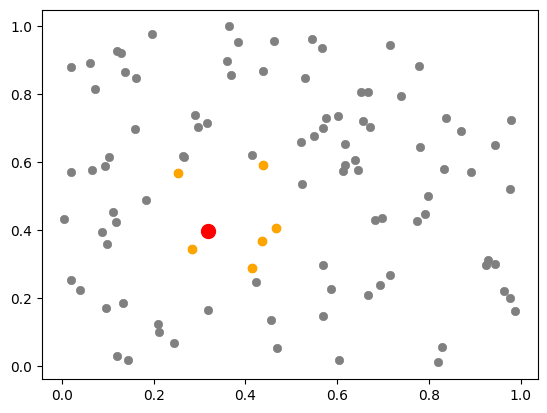

In [85]:
# show neighbors of particle i
i = 90
neighbor_indices = neighbors[i]
plt.scatter(ftr0.x, ftr0.y, color="gray", lw=0.5)
plt.scatter(ftr0.loc[i, "x"], ftr0.loc[i, "y"], color="red", s=100)
plt.scatter(ftr0.loc[neighbor_indices, "x"], ftr0.loc[neighbor_indices, "y"], color="orange")